# Medical Imaging AI Competitions Lack Fairness

## Scope and purpose of this notebook

This notebook documents the computations underlying the results reported in the paper **“Medical Imaging AI Competitions Lack Fairness”**.

It includes all reported numbers and figures and is based on the underlying screening results and following the structure of the *Results* section of the manuscript.

The focus of this notebook is **descriptive analysis**. No model training, parameter optimization, or algorithmic benchmarking is performed.

---

## Data basis and access restrictions

All analyses in this notebook are based on a structured table containing the results of a systematic screening of medical imaging AI competitions.

Due to data protection constraints, this table **cannot be made publicly available**. Access to the raw screening table is therefore restricted.

However:

- All analyses are executed within this notebook.
- All intermediate and final results (counts, percentages, and plots) are explicitly shown.
- No raw data values are required to interpret the reported findings.

---

## Structure of the notebook

The notebook is organized to mirror the **Results section of the manuscript**.

Each major subsection corresponds directly to a results subsection in the paper and follows the same logic:
1. description of the analysis objective,
2. transparent aggregation or filtering steps,
3. presentation of the resulting statistics and visualizations.

In [1]:
import numpy as np
import pandas as pd
from typing import Union, Tuple
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ------------------------------------------------------------
# Read screening data
# ------------------------------------------------------------
df = pd.read_csv("final_challenge_screening_data.csv")
df.columns = df.columns.str.replace('\n', ' ').str.strip()

## Helper functions

The following helper functions are defined to keep the subsequent analysis steps concise and readable.

In [3]:
def count_items_per_task(df: pd.DataFrame, column: str, mode: str = "per_unit", 
                         collapse_below: int = None) -> pd.DataFrame:
    """
    Counts how often each unique item appears in a given column, where entries may contain comma- or semicolin-separated 
    values. 'Not applicable' entries are excluded. 

    Parameters:
        df     : input DataFrame containing one row per analysis unit (e.g. per task)
        column : the name of the column to analyze
        mode:
            'per_unit'   – percentages are normalized by the number of valid rows (i.e., tasks).
            'absolute'   – percentages are normalized by the total number of counted items across all rows.
        collapse_below:
            Minimum count an item must have to be shown separately. Items with counts less than or equal to this 
            threshold are merged into an 'Other' category, except for the labels 'Unclear' and 'Not reported'.

    Returns:
        DataFrame with columns ['Item', 'Count', 'Percentage']
    """
    
    raw = df[column].str.strip()

    # Exclude rows that contain 'not applicable'
    valid = raw[raw != "Not applicable"]

    # Split comma- or semicolon-separated values into individual items
    exploded = valid.str.split(r"[;,]").explode().str.strip()

    counts = exploded.value_counts()
    
    # Define number of units used for percentage calculations based on mode
    if mode == "per_unit":
        n_units = len(valid)
    elif mode == "absolute":
        n_units = counts.sum()
    else:
        raise ValueError("mode must be either 'per_unit' or 'absolute'")
    
    percentages = (counts / n_units * 100).round(1)

    result = pd.DataFrame({
            "Item": counts.index,
            "Count": counts.values,
            "Percentage": percentages.values
        }).reset_index(drop=True)

    # If requested, merge items with low occurence into 'Other' category
    if collapse_below is not None:
        # 'Unclear' and 'Not reported' items should be separated from the 'Other' category
        special_terms = ["Unclear", "Not reported"]

        to_merge = result[(result["Count"] <= collapse_below) & (~result["Item"].isin(special_terms))]
        result = result[~result.index.isin(to_merge.index)]

        if not to_merge.empty:
            other_row = {"Item":"Other", "Count": to_merge.Count.sum(), "Percentage": to_merge.Percentage.sum().round(1)}
            result = pd.concat([result, pd.DataFrame([other_row])], ignore_index=True)

    return result

In [4]:
def count_items_per_challenge(df: pd.DataFrame, column: str, challenge_id_col: str = "Challenge ID", 
                              mode: str = "per_unit", collapse_below: int = None) -> pd.DataFrame:
    """
    Counts how often each unique item appears across challenges. For each challenge, only one representative row per ID is 
    considered in case of multiple challenge tasks to avoid duplicates.
    
    Entries in the specified column may contain comma- or semicolon-separated values; each value is counted individually. 
    Rows with the value 'Not applicable' are excluded.

    Parameters:
        df     : input DataFrame containing one row per analysis unit
        column : the name of the column to analyze
        challenge_id_col:
            Column identifying challenges. Duplicate entries per challenge are removed prior to counting.
        mode:
            'per_unit'   – percentages are normalized by the number of challenges with valid rows.
            'absolute'   – percentages are normalized by the total number of counted items across all challenges.
        collapse_below:
            Minimum count an item must have to be shown separately. Items with counts less than or equal to this 
            threshold are merged into an 'Other' category, except for the labels 'Unclear' and 'Not reported'.

    Returns:
        DataFrame with columns ['Item', 'Count', 'Percentage']
    """
    
    # Only keep one row per challenge
    df_chall_unique = df.drop_duplicates(subset=challenge_id_col)

    result = count_items_per_task(df_chall_unique, column, mode, collapse_below)
    
    return result

In [5]:
def numerical_values_stats(df: pd.DataFrame, column: str, 
                           return_vector: bool = False) -> Union[pd.DataFrame, Tuple[pd.DataFrame, pd.Series], Tuple[pd.DataFrame, pd.Series, pd.Series]]:
    """
    Computes descriptive statistics for a column containing numeric values, while explicitly handling non-numeric entries 
    such as 'Not applicable' or 'Not reported'.

    Cells may contain multiple values separated by comma or semicolons; each value is treated as an independent observation. 
    Only values that can be parsed as numeric are used for the reported statistics.

    Approximate expressions (e.g. '>1', '<=5') are excluded from the numerical statistics but can be returned separately 
    if requested.

    Parameters:
        df: input DataFrame containing one row per analysis unit.
        column: the name of the column to analyze.
        return_vector: if True, also return the vector of valid numeric values used to compute the statistics.

    Returns:
        - stats_df: a DataFrame with descriptive statistics (count, percentage reported, min, mean, median, IQR, max).
        - (stats_df, valid_values): stats_df and a vector of valid numeric values; if return_vector=True.
    """
    raw = df.copy()
    
    raw = raw[column].str.strip().str.replace(",", ".", regex=False)
    exploded = raw.str.split(";").explode().str.strip()
    
    # Remove 'not applicable' entries before parsing numbers
    exploded = exploded[~exploded.str.lower().eq("not applicable")]  
    numeric_series = pd.to_numeric(exploded, errors="coerce")

    # Drop missing values (includes 'Not reported' converted to NaN)
    valid = numeric_series.dropna()

    n_relevant = len(exploded)
    
    # Calculate statistics
    count = valid.count()

    stats = {
        "Count reported": count,
        "Percentage reported": (count / n_relevant * 100).round(1),
        "Min": int(valid.min()),
        "Mean": round(valid.mean(), 2),
        "Median": int(valid.median()),
        "IQR": int(np.percentile(valid, 75) - np.percentile(valid, 25)),
        "Max": int(valid.max())
    }
    
    stats_df = pd.DataFrame([stats])
    
        
    if return_vector:
        return stats_df, valid
    else:
        return stats_df

In [6]:
def only_numbers(df: pd.DataFrame, column: str) -> Tuple[pd.Series, int, float]:
    """
    Extracts numeric values from a column that may contain non-numeric entries and semicolon-separated multiple values. 
    Percent symbols ('%') are removed prior to parsing.

    Rows with the value 'Not applicable' are excluded. Values that cannot be parsed as numbers are ignored.

    Returns:
        valid: Series of parsed numeric values (one per extracted entry).
        count: Number of successfully parsed numeric values.
        percentage:
            Percentage of parsed numeric values relative to the total number of extracted
            entries (after splitting and excluding 'Not applicable').
    """
    raw = df[column].str.strip().str.replace(",", ".", regex=False)
    exploded = raw.str.split(";").explode().str.strip()
    exploded = exploded.str.replace('%', '')

    # Remove 'not applicable' entries before parsing numbers
    exploded = exploded[~exploded.str.lower().eq("not applicable")]  
    numeric_series = pd.to_numeric(exploded, errors="coerce")

    # Drop missing values (includes 'Not reported' converted to NaN)
    valid = numeric_series.dropna()

    n_relevant = len(exploded)

    # Calculate statistics
    count = valid.count()
    percentage = (count / n_relevant * 100).round(1)
    
    return valid, count, percentage

## Current landscape of biomedical image analysis challenges
This section reproduces the analyses underlying the results reported in the subsection **“Current landscape of biomedical image analysis challenges”**.

In [7]:
# Number of challenges
n_challenges = df["Challenge ID"].nunique()
print(f"Number of challenges: {n_challenges}")

# Number of tasks
n_tasks = len(df)
print(f"Number of tasks: {n_tasks}")

# Descriptive statistics on number of tasks
df_unique = df.groupby("Challenge ID", as_index=False).agg({"Year": "first", "Number of tasks used": "first"})
nb_tasks = df_unique["Number of tasks used"]

tasks_stats = {
    "Min": int(nb_tasks.min()),
    "Mean": float(round(nb_tasks.mean(),1)),
    "Median": int(nb_tasks.median()),
    "IQR": int(np.percentile(nb_tasks, 75) - np.percentile(nb_tasks, 25)),
    "Max": int(nb_tasks.max())
}

print(f"Descriptive statistics on number of tasks: {tasks_stats}")

Number of challenges: 241
Number of tasks: 458
Descriptive statistics on number of tasks: {'Min': 1, 'Mean': 1.7, 'Median': 1, 'IQR': 1, 'Max': 10}


In [8]:
# Challenge edition
challenge_edition = count_items_per_challenge(df, "First edition of challenge or second/third/… edition?")
print(challenge_edition)

                            Item  Count  Percentage
0  First edition (new challenge)    171        71.0
1                    2nd edition     33        13.7
2                    3rd edition     15         6.2
3            6th or high edition      9         3.7
4                    4th edition      8         3.3
5                    5th edition      4         1.7
6                   Not reported      1         0.4


In [9]:
# Challenge venue
challenge_venue = count_items_per_challenge(df, "Conference / Venue", collapse_below=3)
print(challenge_venue)

     Item  Count  Percentage
0  MICCAI    160        66.4
1    ISBI     33        13.7
2  Kaggle      6         2.5
3   Other     21         8.4


In [10]:
# Information sources
information_source = count_items_per_task(df, "Information collected from...", mode="absolute")
print(information_source)

                        Item  Count  Percentage
0          Challenge website    445        40.9
1            Challenge paper    257        23.6
2  Challenge design document    247        22.7
3                 Data paper    102         9.4
4               Data website     31         2.9
5     Challenge presentation      4         0.4
6       Paper using the data      1         0.1


In [11]:
## Number of participants
col_test_part = "Number of submissions / participants (test phase)"
col_final_part = "Number of participants (final phase)"

nb_participants_final = numerical_values_stats(df, col_final_part)

print("\nNumber of participants in final phase:")
print(nb_participants_final)


Number of participants in final phase:
   Count reported  Percentage reported  Min   Mean  Median  IQR   Max
0             388                 85.5    0  64.65      12   14  3308


In [12]:
## Ratio of preliminary and final participants

# Keep only rows in which there are entries for both, the number of test and the number of final participants
valid_entries_participants = df[
    df[col_test_part].notna() &
    df[col_final_part].notna()
].copy()

# Remove rows with an entry of 'not reported', 'not applicable', or 'unclear'
invalid_strings_participants = ["not reported", "not applicable", "unclear"]

mask_valid_participants = ~valid_entries_participants[col_test_part].astype(str).str.strip().str.lower().isin(invalid_strings_participants) & \
             ~valid_entries_participants[col_final_part].astype(str).str.strip().str.lower().isin(invalid_strings_participants)

df_participants_ratio = valid_entries_participants[mask_valid_participants].copy()

# Number of tasks with a valid ratio (both entries given)
n_ratio_tasks = len(df_participants_ratio)
p_ratio_tasks = n_ratio_tasks / n_tasks * 100

df_participants_ratio["test_participants"] = df_participants_ratio[col_test_part].astype(float)
df_participants_ratio["final_participants"] = df_participants_ratio[col_final_part].astype(float)

# Calculate ratio between test and final participants
df_participants_ratio["test_final_ratio"] = df_participants_ratio["test_participants"] / df_participants_ratio["final_participants"]

print("Median ratio of test/final participants:", float(df_participants_ratio["test_final_ratio"].median().round(2)))

Median ratio of test/final participants: 2.32


In [13]:
# Stratification of final number of participants according to venue
venues = (df["Conference / Venue"].dropna().str.split(";").explode().str.strip().unique())

strat_part = []

# For each venue, calculate descriptive statistics
for venue in venues:
    df_venue = df[df["Conference / Venue"] == venue]
    
    # Check if entries are empty
    if df_venue[col_final_part].dropna().empty:
        continue
    
    # Skip if no numeric values can be parsed
    numeric = pd.to_numeric(
        df_venue[col_final_part].astype(str).str.replace(",", ".", regex=False).str.split(";").explode().str.strip(),
        errors="coerce").dropna()

    if numeric.empty:
        continue
    
    stats = numerical_values_stats(df_venue, col_final_part)
    stats.insert(0, "Venue", venue)
    
    strat_part.append(stats)

participants_by_venue = pd.concat(strat_part, ignore_index=True)

print(participants_by_venue)

                     Venue  Count reported  Percentage reported  Min     Mean  \
0                   MICCAI             264                 84.9    0    45.23   
1                  NeurIPS               6                100.0    3    15.50   
2                     ISBI              57                 82.6    2    18.63   
3          ML4H conference               1                100.0   10    10.00   
4                    ACMMM               2                100.0    3     5.50   
5                   EE-RDS               1                100.0   33    33.00   
6   ESTRO Physics Workshop               1                100.0    5     5.00   
7                   Kaggle               5                100.0   14  1289.00   
8                     MIDL               2                100.0    6    18.00   
9       Endorsed by MICCAI               1                100.0    9     9.00   
10                  ISICDM               1                100.0   28    28.00   
11                   ICIAR  

In [14]:
# Submission method
submission_method = count_items_per_task(df, "Algorithm or result submission?")
print(submission_method)

                            Item  Count  Percentage
0           Algorithm submission    220        48.1
1              Result submission    212        46.4
2  Algorithm + result submission      9         2.0
3                   Not reported      9         2.0
4                        Unclear      4         0.9
5                Code submission      3         0.7


In [15]:
# Submission method per year
col_submission = "Algorithm or result submission?"
df_submission = df[col_submission].str.strip()

strat_submission = []

for y in range(2018, 2024):
    df_submission= df[df["Year"] == y]
    
    submission_method_year = count_items_per_task(df_submission, col_submission)
    submission_method_year.insert(0, "Year", y)
    
    strat_submission.append(submission_method_year)

submission_by_year = pd.concat(strat_submission, ignore_index=True)

print(submission_by_year)

    Year                           Item  Count  Percentage
0   2018              Result submission     41        73.2
1   2018           Algorithm submission     12        21.4
2   2018                   Not reported      3         5.4
3   2019              Result submission     49        75.4
4   2019           Algorithm submission      9        13.8
5   2019                   Not reported      6         9.2
6   2019                        Unclear      1         1.5
7   2020              Result submission     52        70.3
8   2020           Algorithm submission     18        24.3
9   2020  Algorithm + result submission      4         5.4
10  2021           Algorithm submission     40        58.8
11  2021              Result submission     25        36.8
12  2021                        Unclear      3         4.4
13  2022           Algorithm submission     59        70.2
14  2022              Result submission     25        29.8
15  2023           Algorithm submission     82        74

In [16]:
# Sample sizes
col_train = "Number of training cases"
col_val = "Number of validation cases, if given specifically by the organizers (if any)"
col_test = "Number of phase 2 test cases (final test cases)"

nb_training, values_training = numerical_values_stats(df, col_train, True)
nb_val, values_val = numerical_values_stats(df, col_val, True)
nb_test, values_test = numerical_values_stats(df, col_test, True)

print("=== Training ===")
print(nb_training)
print("\n=== Validation ===")
print(nb_val)
print("\n=== Test ===")
print(nb_test)

=== Training ===
   Count reported  Percentage reported  Min     Mean  Median   IQR     Max
0             429                 93.9    0  4246.49     288  1130  530706

=== Validation ===
   Count reported  Percentage reported  Min    Mean  Median  IQR    Max
0             156                 91.2    1  411.87      80  170  18368

=== Test ===
   Count reported  Percentage reported  Min    Mean  Median  IQR    Max
0             394                 86.2    1  704.81     102  324  47227


In [17]:
# Ratio of training and test cases
valid_entries_nb_data = df[df[col_train].notna() & df[col_test].notna()].copy()

exploded_train = valid_entries_nb_data[col_train].str.split(r"[;,]").explode().str.strip()
exploded_test = valid_entries_nb_data[col_test].str.split(r"[;,]").explode().str.strip()

exploded_entries_nb_data = pd.concat([exploded_train, exploded_test], axis=1)

invalid_strings_nb_data = ["not reported", "not applicable", "unclear"]

mask_valid_nb_data = ~exploded_entries_nb_data[col_train].astype(str).str.strip().str.lower().isin(invalid_strings_nb_data) & \
             ~exploded_entries_nb_data[col_test].astype(str).str.strip().str.lower().isin(invalid_strings_nb_data)

df_nb_data_ratio = exploded_entries_nb_data[mask_valid_nb_data].copy()

# Number of tasks with a valid ratio (both entries given)
n_ratio_tasks_nb_data = len(df_nb_data_ratio)
p_ratio_tasks_nb_data = n_ratio_tasks_nb_data / n_tasks * 100

df_nb_data_ratio["train_data"] = df_nb_data_ratio[col_train].astype(float)
df_nb_data_ratio["test_data"] = df_nb_data_ratio[col_test].astype(float)

# Calculate ratio between training and test data
df_nb_data_ratio["train_test_ratio"] = df_nb_data_ratio["train_data"] / df_nb_data_ratio["test_data"]

print("Median ratio training/test data:", df_nb_data_ratio["train_test_ratio"].median())

Median ratio training/test data: 2.22863328313253


In [18]:
# Type of award
award_type = count_items_per_task(df, "Type of award")
print(award_type)

                                                Item  Count  Percentage
0                                       Not reported    195        43.0
1                                        Award money    177        39.0
2                                              Other     37         8.1
3                 Compute infrastructure (e.g. GPUs)     25         5.5
4                    Award money + compute resources     12         2.6
5  Cost reimbursement (e.g. travel or conference ...      2         0.4
6                                            Unclear      2         0.4


In [19]:
# Amount of money
award_raw = df["Amount of money (summed up)"].dropna().astype(str).str.strip()
award_valid = award_raw[~award_raw.str.lower().eq("not applicable")]

# Extract values and currencies
award_extracted = award_valid.str.extract(r"(?P<amount>[\d.,]+)\s*(?P<currency>[A-Za-z]{3})")
award_extracted["amount"] = award_extracted["amount"].str.replace(",", "", regex=False).astype(float)

award_parsed = pd.DataFrame({
    "Award raw": award_valid,
    "Award amount": award_extracted["amount"],
    "Award currency": award_extracted["currency"].str.upper()
})

exchange_rates_to_eur = {
    "EUR": 1.00,
    "USD": 0.87,
    "CHF": 1.06,
    "CAD": 0.63,
    "GBP": 1.17,
    "CNY": 0.12,
    "RMB": 0.12  
}

award_parsed["Award amount EUR"] = award_parsed.apply(
    lambda row: row["Award amount"] * exchange_rates_to_eur[row["Award currency"]]
    if pd.notnull(row["Award amount"]) else None,
    axis=1
)

award_parsed["Award amount EUR"].describe()

count       170.000000
mean       6046.305118
std       13124.598180
min         117.000000
25%         970.000000
50%        1813.500000
75%        4350.000000
max      120000.000000
Name: Award amount EUR, dtype: float64

In [20]:
# Post-challenge submission 
post_challenge_submission = count_items_per_task(df, "Post-challenge submission possible?")

print("Post-challenge submission possible?:", post_challenge_submission)

Post-challenge submission possible?:            Item  Count  Percentage
0            No    308        67.5
1           Yes    139        30.5
2  Not reported      5         1.1
3       Unclear      4         0.9


In [21]:
## Challenge or data publications
pub_cols = ['Challenge publication link', 'Data publication link']
pubs = {}

for pub_col in pub_cols:
    # Count entries that are either NaN or string "None"
    df_pub = df[pub_col]
    pub_missing = df_pub.isna() | (df_pub == "None")
    pub_n_missing = pub_missing.sum()
    pub_n = n_tasks - pub_n_missing
    pub_p = round(pub_n / n_tasks * 100, 2)

    pubs[pub_col] = (pub_n, pub_p)
    
# Output results
print("Publications (per task):")
for col, (count, percent) in pubs.items():
    print(f"- {col}: {count} tasks with publication ({percent}%)")
    
    
has_challenge_pub = ~(df[pub_cols[0]].isna() | (df[pub_cols[0]] == "None"))
has_data_pub = ~(df[pub_cols[1]].isna() | (df[pub_cols[1]] == "None"))

both_present = (has_challenge_pub & has_data_pub).sum()
only_challenge = (has_challenge_pub & ~has_data_pub).sum()
only_data = (~has_challenge_pub & has_data_pub).sum()
neither_present = (~has_challenge_pub & ~has_data_pub).sum()
either_present = (has_challenge_pub | has_data_pub).sum()

# Output: combinations
print("\nPublication availability combinations (per task):")
print(f"- Both challenge and data publications: {both_present} ({both_present / n_tasks:.1%})")
print(f"- Only challenge publication:           {only_challenge} ({only_challenge / n_tasks:.1%})")
print(f"- Only data publication:                {only_data} ({only_data / n_tasks:.1%})")
print(f"- Either provided:                      {either_present} ({either_present / n_tasks:.1%})")
print(f"- Neither provided:                     {neither_present} ({neither_present / n_tasks:.1%})")

Publications (per task):
- Challenge publication link: 259 tasks with publication (56.55%)
- Data publication link: 114 tasks with publication (24.89%)

Publication availability combinations (per task):
- Both challenge and data publications: 72 (15.7%)
- Only challenge publication:           187 (40.8%)
- Only data publication:                42 (9.2%)
- Either provided:                      301 (65.7%)
- Neither provided:                     157 (34.3%)


In [22]:
# Helper masks
has_challenge_pub = df["Challenge publication link"].notna() & (df["Challenge publication link"] != "None")
has_data_pub = df["Data publication link"].notna() & (df["Data publication link"] != "None")

# Counts
challenge_pub_n = has_challenge_pub.sum()
data_pub_n = has_data_pub.sum()
either_pub_n = (has_challenge_pub | has_data_pub).sum()
both_pub_n = (has_challenge_pub & has_data_pub).sum()

# Percentages
challenge_pub_p = round(challenge_pub_n / n_tasks * 100, 1)
data_pub_p = round(data_pub_n / n_tasks * 100, 1)
either_pub_p = round(either_pub_n / n_tasks * 100, 1)
both_pub_p = round(both_pub_n / n_tasks * 100, 1)

# Output
print("Tasks with publication(s):")
print(f"- Challenge publication: {challenge_pub_p}%")
print(f"- Data publication: {data_pub_p}%")
print(f"- Either: {either_pub_p}%")
print(f"- Both: {both_pub_p}%")

Tasks with publication(s):
- Challenge publication: 56.6%
- Data publication: 24.9%
- Either: 65.7%
- Both: 15.7%


In [23]:
## Challenge papers: number of citations per year
col_chall_date = 'Challenge paper: Publication date'
col_chall_cit = 'Challenge paper: Number of citations'
col_year = 'Year'
col_start_date = 'Start date'

df_chall_pap = df[[col_year, col_start_date, col_chall_date, col_chall_cit]].copy()

# Convert 'not reported' / 'not applicable' to NAs
df_chall_pap = df_chall_pap.replace({"Not reported": pd.NA, "Not applicable": pd.NA})

# Remove rows with at least one NA entries
df_chall_pap = df_chall_pap.dropna(subset=[col_chall_date, col_chall_cit])

# Fix date formats
df_chall_pap[col_chall_date] = pd.to_datetime(
    df_chall_pap[col_chall_date], 
    format="%d.%m.%Y", 
    errors="coerce"
)

df_chall_pap[col_start_date] = pd.to_datetime(
    df_chall_pap[col_start_date], 
    format="%d.%m.%Y", 
    errors="coerce"
)

# Convert citations column to numeric
df_chall_pap[col_chall_cit] = pd.to_numeric(df_chall_pap[col_chall_cit], errors="coerce")

# Cutoff: Date of capturing the number of citations
cutoff = pd.Timestamp("2025-06-17")

# Calculate citations per year
df_chall_pap['years_since_pub'] = (cutoff - df_chall_pap[col_chall_date]).dt.days / 365.25
df_chall_pap['citations_per_year'] = df_chall_pap[col_chall_cit] / df_chall_pap['years_since_pub']

# Descriptive statistics
stats_chall_pap = df_chall_pap['citations_per_year'].agg(['median', 'max'])
print("Challenge publication citations per year\n", stats_chall_pap)

Challenge publication citations per year
 median     19.761660
max       444.250702
Name: citations_per_year, dtype: float64


In [24]:
## Data papers: number of citations per year
col_dat_date = 'Data paper: Publication date'
col_dat_cit = 'Data paper: Number of citations'

df_dat_pap = df[[col_year, col_start_date, col_dat_date, col_dat_cit]].copy()

# Convert 'not reported' / 'not applicable' to NAs
df_dat_pap = df_dat_pap.replace({"Not reported": pd.NA, "Not applicable": pd.NA})

# Remove rows with missing entries
df_dat_pap = df_dat_pap.dropna(subset=[col_dat_date, col_dat_cit])

# Split entries with multiple values (on ; or ,)
df_dat_pap[col_dat_date] = df_dat_pap[col_dat_date].astype(str).str.split(r"[;,]").explode().str.strip().reset_index(drop=True)
df_dat_pap[col_dat_cit] = df_dat_pap[col_dat_cit].astype(str).str.split(r"[;,]").explode().str.strip().reset_index(drop=True)

# Fix date formats
df_dat_pap[col_dat_date] = pd.to_datetime(df_dat_pap[col_dat_date], format="%d.%m.%Y", errors="coerce")
df_dat_pap[col_dat_cit]  = pd.to_numeric(df_dat_pap[col_dat_cit], errors="coerce")
df_dat_pap[col_start_date] = pd.to_datetime(df_dat_pap[col_start_date], format="%d.%m.%Y", errors="coerce")

# Cutoff: Date of capturing the number of citations
cutoff = pd.Timestamp("2025-06-17")

# Calculate citations per year
df_dat_pap['years_since_pub'] = (cutoff - df_dat_pap[col_dat_date]).dt.days / 365.25
df_dat_pap['citations_per_year'] = df_dat_pap[col_dat_cit] / df_dat_pap['years_since_pub']

# Descriptive statistics
stats_dat_pap = df_dat_pap['citations_per_year'].agg(['median', 'max'])
print("Data publication citations per year\n", stats_dat_pap)

Data publication citations per year
 median     21.679535
max       141.401046
Name: citations_per_year, dtype: float64


In [25]:
## Challenge papers: publication delay

# Calculate latency in publication (in years)
df_chall_pap['latency_years'] = (df_chall_pap[col_chall_date] - df_chall_pap[col_start_date]).dt.days / 30.44 / 12

# Descriptive statistics
stats_chall_lat = df_chall_pap['latency_years'].agg(['median', 'max'])
print("\nChallenge publication latency years \n", stats_chall_lat)


Challenge publication latency years 
 median    1.552234
max       6.641481
Name: latency_years, dtype: float64


## Figure 1
This section reproduces the analyses underlying the results presented in **Figure 1**.


Number of tasks per year:
Year
2018     56
2019     65
2020     74
2021     69
2022     84
2023    110
Name: count, dtype: int64

Number of challenges per year:
Year
2018    23
2019    39
2020    42
2021    37
2022    52
2023    57
Name: count, dtype: int64


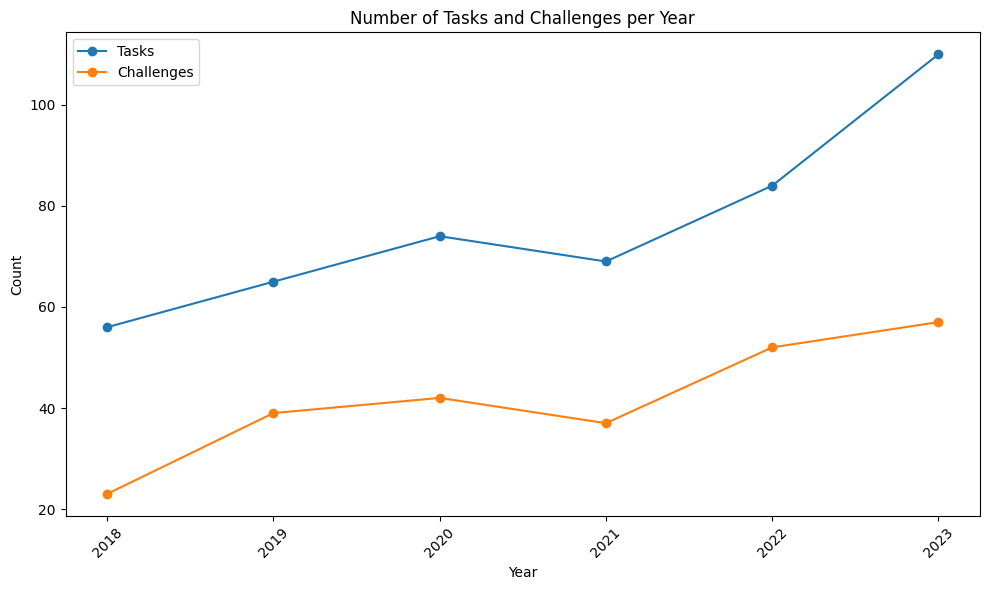

In [26]:
## Figure 1a: Number of challenges and tasks per year
# Number of tasks per year
tasks_per_year = df["Year"].value_counts().sort_index()
print("\nNumber of tasks per year:")
print(tasks_per_year)

# Number of challenges per year
challenge_year_df = df[["Year", "Challenge ID"]].drop_duplicates()
challenges_per_year = challenge_year_df["Year"].value_counts().sort_index()
print("\nNumber of challenges per year:")
print(challenges_per_year)

# Plot number of challenges and tasks per year
summary_df = pd.DataFrame({
    "Tasks": tasks_per_year,
    "Challenges": challenges_per_year
}).fillna(0).astype(int)

ax = summary_df.plot(kind="line", figsize=(10, 6), marker="o")

ax.set_title("Number of Tasks and Challenges per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
## Figure 1b: Body regions
anatom_region_tasks = count_items_per_task(df, "Anatomical region(s)" , collapse_below=11)
print(anatom_region_tasks)

            Item  Count  Percentage
0          Brain    132        29.7
1            Eye     43         9.7
2          Colon     43         9.7
3           Lung     38         8.5
4          Heart     29         6.5
5        Abdomen     28         6.3
6          Liver     28         6.3
7         Breast     27         6.1
8         Kidney     24         5.4
9       Prostate     23         5.2
10  Not reported     16         3.6
11       Stomach     15         3.4
12          Head     15         3.4
13          Neck     14         3.1
14      Pancreas     14         3.1
15        Spleen     13         2.9
16       Bladder     12         2.7
17         Other    139        30.6


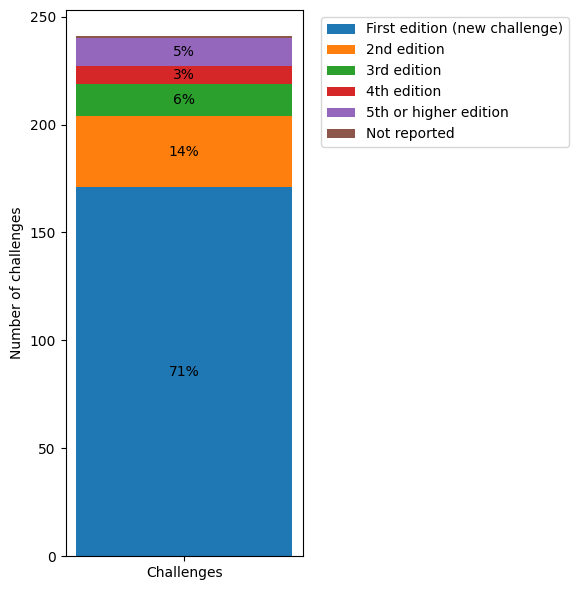

In [28]:
challenge_edition_plot = challenge_edition.copy()

# Merge editions
challenge_edition_plot["Edition_grouped"] = challenge_edition_plot["Item"].replace({
    "5th edition": "5th or higher edition",
    "6th or high edition": "5th or higher edition"
})

challenge_edition_plot = (challenge_edition_plot.groupby("Edition_grouped", as_index=False).agg({"Count": "sum", "Percentage": "sum"}))

challenge_edition_order = ["First edition (new challenge)", "2nd edition", "3rd edition", "4th edition",
    "5th or higher edition", "Not reported"]

challenge_edition_plot["Edition_grouped"] = pd.Categorical(challenge_edition_plot["Edition_grouped"], 
                                                           categories=challenge_edition_order, ordered=True)

challenge_edition_plot = challenge_edition_plot.sort_values("Edition_grouped")

fig, ax = plt.subplots(figsize=(6, 6))

bottom = 0
for _, row in challenge_edition_plot.iterrows():
    ax.bar("Challenges", row["Count"], bottom=bottom, label=row["Edition_grouped"])
    if row["Percentage"] > 1:
        ax.text(0, bottom + row["Count"] / 2, f'{row["Percentage"]:.0f}%', ha="center", va="center", fontsize=10)

    bottom += row["Count"]

ax.set_ylabel("Number of challenges")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

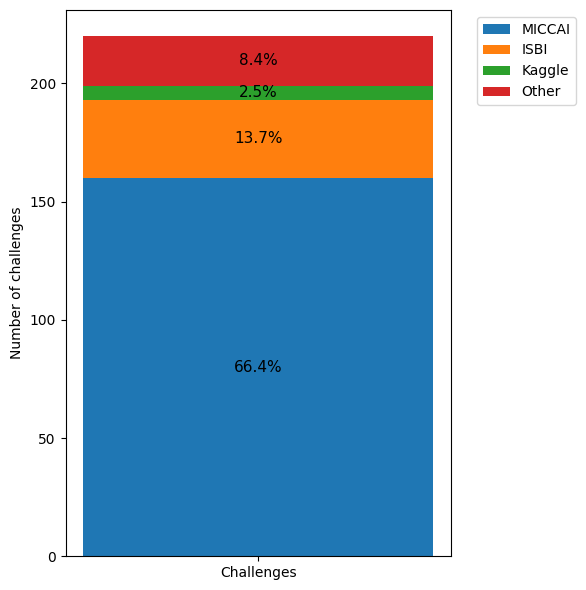

In [29]:
## Figure 1d: Challenge venue
venue_plot = challenge_venue.copy()
venues_include = ["MICCAI", "ISBI", "Kaggle"]

venue_plot["Venue_grouped"] = venue_plot["Item"].where(venue_plot["Item"].isin(venues_include), "Other")

venue_plot = (venue_plot.groupby("Venue_grouped", as_index=False).agg({"Count": "sum", "Percentage": "sum"}))

order_venue = ["MICCAI", "ISBI", "Kaggle", "Other"]

venue_plot["Venue_grouped"] = pd.Categorical(venue_plot["Venue_grouped"], categories=order_venue, ordered=True)

venue_plot = venue_plot.sort_values("Venue_grouped")

fig, ax = plt.subplots(figsize=(6, 6))

bottom = 0
for _, row in venue_plot.iterrows():
    ax.bar("Challenges", row["Count"], bottom=bottom, label=row["Venue_grouped"])

    if row["Percentage"] > 1:
        ax.text(0, bottom + row["Count"] / 2, f'{row["Percentage"]:.1f}%', ha="center", va="center", fontsize=11)

    bottom += row["Count"]

ax.set_ylabel("Number of challenges")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

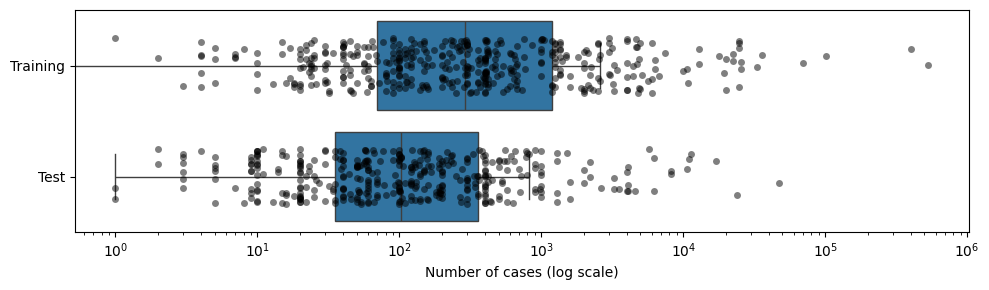

In [30]:
## Figure 1e: Sample size
# 2) Only train and test
df_violin = pd.DataFrame({
    "Training": values_training.reset_index(drop=True),
    "Test": values_test.reset_index(drop=True),
})

df_violin_long = df_violin.melt(var_name="Split", value_name="Number of Images")

plt.figure(figsize=(10,3))
sns.boxplot(data=df_violin_long, y="Split", x="Number of Images", showfliers=False)
sns.stripplot(
    data=df_violin_long,
    y="Split",
    x="Number of Images",
    color="black",
    size=5,
    jitter=0.25,
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Number of cases (log scale)")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Representativeness is limited by substantial geographic and thematic imbalance
This section reproduces the analyses underlying the results reported in the subsection **“Representativeness is limited by substantial geographic and thematic imbalance”**.

In [31]:
# Geographical distribution
data_location = count_items_per_task(df, "Data location (countries/cities)")

# Combine all US entries
data_location_us_combined = data_location.copy()
data_location_us_combined["Item"] = data_location_us_combined["Item"].replace(regex=r"^US\s*\(.*\)", value="US")

data_location_us_combined = data_location_us_combined.groupby("Item", as_index=False).agg({
    "Count": "sum",
    "Percentage": "sum" 
})

data_location_us_combined = data_location_us_combined.sort_values(by="Count", ascending=False)
print(data_location_us_combined)

oceania_countries = [
    "Australia",
    "New Zealand",
]

south_america_countries = [
    "Brazil",
    "Chile",
    "Argentina",
]

africa_countries = [
    "Egypt",
    "Nigeria",
    "Morocco",
    "Africa",  # unspecific entry in the table
]

df_oceania = data_location_us_combined[data_location_us_combined["Item"].isin(oceania_countries)]
df_south_america = data_location_us_combined[data_location_us_combined["Item"].isin(south_america_countries)]
df_africa = data_location_us_combined[data_location_us_combined["Item"].isin(africa_countries)]

print("\nOceania: ", df_oceania)
print("\nSouth America: ", df_south_america)
print("\nAfrica: ", df_africa)

               Item  Count  Percentage
42               US    318        70.4
27     Not reported    100        22.1
9             China     74        16.4
14          Germany     57        12.6
39  The Netherlands     46        10.2
41               UK     46        10.2
36      Switzerland     42         9.3
13           France     41         9.1
19            Italy     29         6.4
16            India     23         5.1
7            Canada     22         4.9
15          Hungary     17         3.8
34            Spain     17         3.8
26           Norway     10         2.2
2         Australia      9         2.0
40           Turkey      8         1.8
29         Portugal      7         1.5
33      South Korea      7         1.5
35           Sweden      7         1.5
18           Israel      5         1.1
3           Austria      5         1.1
30           Russia      5         1.1
4           Belgium      5         1.1
6            Brazil      4         0.9
11          Denmark      

In [32]:
# Problem category
problem_category = count_items_per_task(df, "Problem category", collapse_below=5)
print(problem_category)

              Item  Count  Percentage
0     Segmentation    180        39.3
1   Classification     97        21.2
2        Detection     58        12.7
3     Registration     36         7.9
4   Reconstruction     14         3.1
5       Prediction     12         2.6
6       Regression      9         2.0
7     Localization      7         1.5
8        Synthesis      6         1.3
9          Unclear      2         0.4
10           Other     64        13.6


In [33]:
# Imaging modalities
imag_modal = count_items_per_task(df, "Imaging modality(ies)", collapse_below=2)
print(imag_modal)

                       Item  Count  Percentage
0                       MRI    159        35.2
1                        CT     95        21.0
2   Laparoscopy / Endoscopy     59        13.1
3            Histopathology     48        10.6
4      (Fundus) Photography     27         6.0
5                Microscopy     20         4.4
6                        US     20         4.4
7                     X-Ray     17         3.8
8                       OCT     13         2.9
9                    PET/CT      8         1.8
10               Dermoscopy      7         1.5
11             Not reported      7         1.5
12           Natural images      4         0.9
13                      PET      4         0.9
14                    Other      8         1.6


In [34]:
## Body regions
print(anatom_region_tasks)

            Item  Count  Percentage
0          Brain    132        29.7
1            Eye     43         9.7
2          Colon     43         9.7
3           Lung     38         8.5
4          Heart     29         6.5
5        Abdomen     28         6.3
6          Liver     28         6.3
7         Breast     27         6.1
8         Kidney     24         5.4
9       Prostate     23         5.2
10  Not reported     16         3.6
11       Stomach     15         3.4
12          Head     15         3.4
13          Neck     14         3.1
14      Pancreas     14         3.1
15        Spleen     13         2.9
16       Bladder     12         2.7
17         Other    139        30.6


In [35]:
# Number of centers
nb_centers, values_centers = numerical_values_stats(df, "Number of centers", True)
print(nb_centers)

   Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0             323                 71.9    1  5.98       1    2  500


In [36]:
# Number of devices
nb_devices, values_devices = numerical_values_stats(df, "Number of devices", True)
print(nb_devices)

   Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0             256                 56.6    1  2.46       2    2   18


In [37]:
## Sex distribution
values_male, count_male, percentage_male = only_numbers(df, "If human data: amount of male")
values_female, count_female, percentage_female = only_numbers(df, "If human data: amount of female")

print("Male (%; median):", int(values_male.median()))
print("Female (%; median):", int(values_female.median()))

Male (%; median): 52
Female (%; median): 47


In [38]:
## Age distribution
age_min, values_age_min = numerical_values_stats(df, "If human data: minimum age", True)
age_mean, values_age_mean = numerical_values_stats(df, "If human data: mean age", True)
age_median, values_age_median = numerical_values_stats(df, "If human data: median age", True)
age_max, values_age_max = numerical_values_stats(df, "If human data: maximum age", True)

# Descriptive stats over reported mean ages
print("\nMean age descriptive statistics:\n", age_mean)

# Calculate overall min and max ages
ages_all = np.concatenate([
    values_age_min,
    values_age_mean,
    values_age_median,
    values_age_max
])

print("\nOverall minimum age:", float(ages_all.min()))
print("Overall maximum age:", float(ages_all.max()))

# Calculate how many tasks report all values
age_cols = ["If human data: minimum age", "If human data: mean age", 
            "If human data: median age", "If human data: maximum age"]

# Calculate how many tasks reported any age information
mask_any_reported = df[age_cols].apply(pd.to_numeric, errors="coerce").notna().any(axis=1)
n_any_reported = mask_any_reported.sum()

raw = df["If human data: minimum age"]
valid = raw[~raw.str.lower().eq("not applicable")]

n_total = len(valid)
share_any_reported = n_any_reported / n_total

print(f"\nPercentage of tasks reporting any information on age distribution: {share_any_reported:.0%}")


Mean age descriptive statistics:
    Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0              77                 18.3    0  49.9      54   13   72

Overall minimum age: 0.0
Overall maximum age: 100.0

Percentage of tasks reporting any information on age distribution: 26%


In [39]:
# Number of annotators (total)
nb_annot_total, values_annot_total = numerical_values_stats(df, "Number of annotators (total)", True)
print(nb_annot_total)

   Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0             235                 61.0    1  6.77       3    4   92


In [40]:
# Number of annotators (per case)
nb_annot_case, values_annot_case = numerical_values_stats(df, "Number of annotators per case", True)
print(nb_annot_case)

   Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0             207                 53.8    1  2.14       2    1    7


## Figure 2
This section reproduces the analyses underlying the results presented in **Figure 2**.

In [41]:
## Figure 2a: Geographical distribution
print(data_location_us_combined)

               Item  Count  Percentage
42               US    318        70.4
27     Not reported    100        22.1
9             China     74        16.4
14          Germany     57        12.6
39  The Netherlands     46        10.2
41               UK     46        10.2
36      Switzerland     42         9.3
13           France     41         9.1
19            Italy     29         6.4
16            India     23         5.1
7            Canada     22         4.9
15          Hungary     17         3.8
34            Spain     17         3.8
26           Norway     10         2.2
2         Australia      9         2.0
40           Turkey      8         1.8
29         Portugal      7         1.5
33      South Korea      7         1.5
35           Sweden      7         1.5
18           Israel      5         1.1
3           Austria      5         1.1
30           Russia      5         1.1
4           Belgium      5         1.1
6            Brazil      4         0.9
11          Denmark      

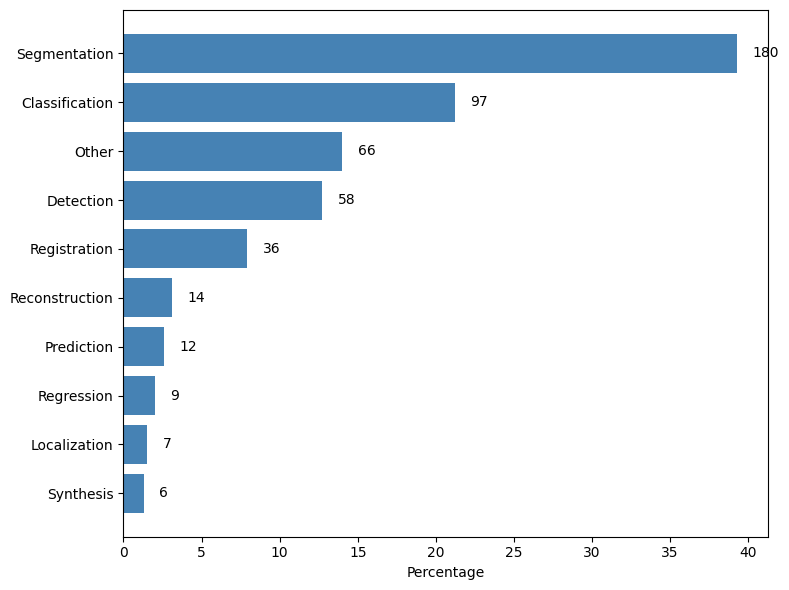

In [42]:
## Figure 2b: Problem categories
problem_category_plot = problem_category.copy()

# Merge unclear and other options
problem_category_plot["Prob_grouped"] = problem_category_plot["Item"].replace({"Unclear": "Other"})

problem_category_plot = (problem_category_plot.groupby("Prob_grouped", as_index=False).agg({"Count": "sum", "Percentage": "sum"}))

problem_category_plot = problem_category_plot.sort_values("Count", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(problem_category_plot["Prob_grouped"], problem_category_plot["Percentage"], color="steelblue")

for bar, pct in zip(bars, problem_category_plot["Count"]):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f"{pct}", va="center")

plt.xlabel("Percentage")
plt.tight_layout()
plt.show()

                       Item  Count  Percentage
0                       MRI    159        35.2
1                        CT     95        21.0
2   Laparoscopy / Endoscopy     59        13.1
3            Histopathology     48        10.6
4      (Fundus) Photography     27         6.0
5                Microscopy     20         4.4
6                        US     20         4.4
7                     X-Ray     17         3.8
8                       OCT     13         2.9
9                    PET/CT      8         1.8
10               Dermoscopy      7         1.5
11             Not reported      7         1.5
12           Natural images      4         0.9
13                      PET      4         0.9
14                    Other      8         1.6


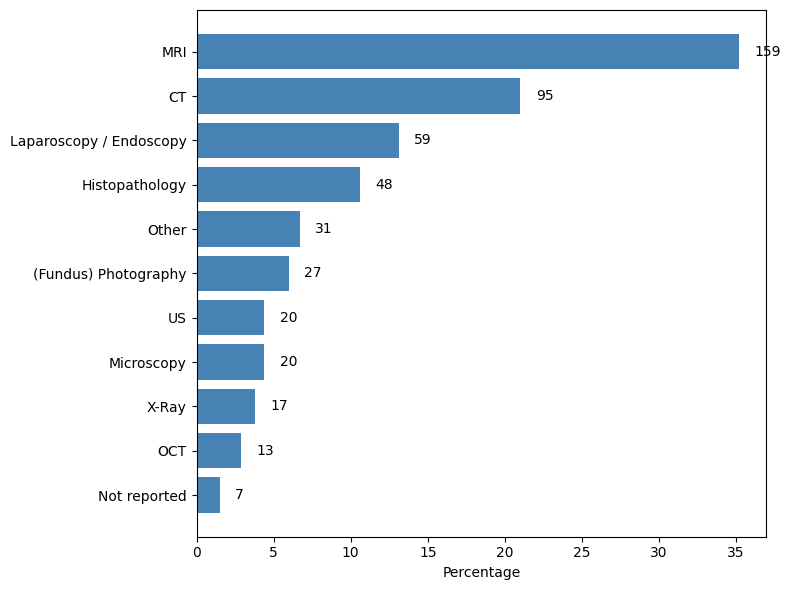

In [43]:
## Figure 2c: Imaging modalities
imag_modal_plot = imag_modal.copy()
print(imag_modal)

# Merge rare modalities to 'Other'
imag_modal_plot["Mod_grouped"] = imag_modal_plot["Item"].replace({
    "PET/CT": "Other",
    "Dermoscopy": "Other",
    "PET": "Other",
    "Natural images": "Other"
})

imag_modal_plot = (imag_modal_plot.groupby("Mod_grouped", as_index=False).agg({"Count": "sum", "Percentage": "sum"}))

# Plot
imag_modal_plot = imag_modal_plot.sort_values("Count", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(imag_modal_plot["Mod_grouped"], imag_modal_plot["Percentage"], color="steelblue")

for bar, pct in zip(bars, imag_modal_plot["Count"]):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f"{pct}", va="center")

plt.xlabel("Percentage")
plt.tight_layout()
plt.show()

## Accessibility and licensing practices limit responsible data reuse
This section reproduces the analyses underlying the results reported in the subsection **“Accessibility and licensing practices limit responsible data reuse”**.

In [44]:
# Data publicly available
data_avail = count_items_per_task(df, "Data publicly available?")
print(data_avail)

        Item  Count  Percentage
0        Yes    370        80.8
1         No     65        14.2
2  Partially     14         3.1
3    Unclear      9         2.0


In [45]:
# Score for rating data sharing
score_data_sharing, score_data_sharing_values = numerical_values_stats(df, "Score for rating data sharing", return_vector=True)
print(score_data_sharing)

score_data_sharing_value_countstest = score_data_sharing_values.value_counts().sort_index()
threshold = 2.5
n_leq = (score_data_sharing_values <= threshold).sum()
pct_leq = round(n_leq / len(score_data_sharing_values) * 100, 1)

print(f"\n{n_leq} tasks ({pct_leq}%) have a score of {threshold} or lower.")

   Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0             459                 99.8    0  2.69       3    2    5

212 tasks (46.2%) have a score of 2.5 or lower.


In [46]:
# Licenses
lic_reported = count_items_per_task(df, "Data license reported?")
unamb_lic = count_items_per_task(df, "Unambiguous license?")

print("Data license reported?")
print(lic_reported)
print("\nUnambiguous license?")
print(unamb_lic)

Data license reported?
                             Item  Count  Percentage
0  Described in sufficient detail    271        59.3
1           Only partly described    122        26.7
2            Not described at all     64        14.0

Unambiguous license?
           Item  Count  Percentage
0            No    262        57.6
1           Yes    187        41.1
2  Not reported      6         1.3


In [47]:
# License types (rough)
lic_type = count_items_per_task(df, "Custom license or standard license?")
print(lic_type)

# CC modified licenses
cc_modified_items = ["Creative Commons license + Custom", "Standard license modified", "Creative Commons license (modified)"]
cc_modified = lic_type.loc[lic_type["Item"].isin(cc_modified_items),"Percentage"].sum()

print(f"\nCC license modified: {cc_modified:.1f}%")

                                   Item  Count  Percentage
0   Creative Commons license (standard)    234        51.2
1     Creative Commons license + Custom     77        16.8
2                        Custom license     64        14.0
3                          Not reported     57        12.5
4      Open Database license (standard)     13         2.8
5             Standard license modified      7         1.5
6                                 Other      6         1.3
7                               Unclear      4         0.9
8                            No license      3         0.7
9   BSD or MIT type licenses (standard)      2         0.4
10  Creative Commons license (modified)      2         0.4
11                                 TCIA      1         0.2

CC license modified: 18.7%


In [48]:
# License types (fine-granular)
lic_type_detailed = count_items_per_task(df, "Data license", mode="absolute")
print(lic_type_detailed)

                                  Item  Count  Percentage
0                       Custom license    144        28.6
1                                CC BY     92        18.3
2                          CC BY-NC-SA     89        17.7
3                          CC BY-NC-ND     73        14.5
4                             CC BY-NC     56        11.1
5   Open access dHCP data terms of use     13         2.6
6                             CC BY-SA     13         2.6
7                                  CC0      9         1.8
8                                 TCIA      5         1.0
9                              Unclear      4         0.8
10                         MIT License      2         0.4
11                       Public domain      2         0.4
12                            CC BY-ND      1         0.2


In [49]:
# Restrictive vs permissive licenses
permissive = ["CC BY", "CC BY-SA", "CC0", "MIT License", "Public domain", "TCIA"]
restrictive = ["CC BY-NC", "CC BY-NC-SA", "CC BY-NC-ND", "CC BY-ND"]
unclear_or_custom = ["Custom license", "Open access dHCP data terms of use", "Unclear"]

permissive_pct = lic_type_detailed.loc[lic_type_detailed["Item"].isin(permissive), "Percentage"].sum()
restrictive_pct = lic_type_detailed.loc[lic_type_detailed["Item"].isin(restrictive), "Percentage"].sum()
unclear_pct = lic_type_detailed.loc[lic_type_detailed["Item"].isin(unclear_or_custom), "Percentage"].sum()

print(f"Permissive licenses: {permissive_pct:.1f}%")
print(f"Restrictive licenses: {restrictive_pct:.1f}%")
print(f"Unclear or custom licenses: {unclear_pct:.1f}%")

Permissive licenses: 24.5%
Restrictive licenses: 43.5%
Unclear or custom licenses: 32.0%


In [50]:
# Same license as submitted during peer review?
same_lic_miccai = count_items_per_task(df, "Was the exact same license applied as stated in the challenge proposal accepted by the MICCAI chairs?")
print(same_lic_miccai)

           Item  Count  Percentage
0           Yes    100        40.2
1            No     82        32.9
2  Not reported     67        26.9


In [51]:
## License inconsistencies
col_incons = "Cases of inconsistencies"

inconsistencies_task = count_items_per_task(df, col_incons)

# Calculate inconsistency categories
inconsistencies_to_category = {
        "No inconsistencies": "correct",
    
        "Platform registration under restrictive license": "uncertain / borderline",
        "Approval-based access under restrictive license": "uncertain / borderline",
        "Context-limited access under restrictive license": "uncertain / borderline",
        "NoDerivatives clause": "uncertain / borderline",
        "Additional data use agreement mentioned": "uncertain / borderline",
        "Software-style license applied to dataset": "uncertain / borderline",
    
        "Platform registration despite open license": "inconsistent / misleading (pseudo-open)",
        "Approval-based access despite open license": "inconsistent / misleading (pseudo-open)",
        "Context-limited access despite open license": "inconsistent / misleading (pseudo-open)",
        "Declared license without accessible data": "inconsistent / misleading (pseudo-open)",
    
        "Conflicting or contradictory license terms": "impermissible / non-compliant",
        "Conflicting license statements across sources": "impermissible / non-compliant",
        "Incompatible license combination": "impermissible / non-compliant",
        "License missing or not findable": "impermissible / non-compliant",
        "Violation of general license terms": "impermissible / non-compliant",
    }

df_inconsistencies = df.copy()

inconsistencies_raw = df_inconsistencies["Cases of inconsistencies"].astype(str).str.strip()
inconsistencies_valid = inconsistencies_raw[inconsistencies_raw != "Not applicable"]

inconsistencies_categories = inconsistencies_valid.str.split(r"[;,]").apply(
        lambda lst: sorted(set(
            inconsistencies_to_category.get(x.strip())
            for x in lst if inconsistencies_to_category.get(x.strip())
        ))
    )

inconsistencies_exploded = inconsistencies_categories.explode().dropna()

incons_counts = inconsistencies_exploded.value_counts()
n_tasks_incons = len(inconsistencies_valid)

inconsistencies_result = pd.DataFrame({
    "Item": incons_counts.index,
    "Count": incons_counts.values,
    "Percentage": (incons_counts / n_tasks_incons * 100).round(1)
}).reset_index(drop=True)

print("Number of tasks in scope:", n_tasks_incons)
print(inconsistencies_result)

Number of tasks in scope: 398
                                      Item  Count  Percentage
0                   uncertain / borderline    171        43.0
1            impermissible / non-compliant    153        38.4
2                                  correct     80        20.1
3  inconsistent / misleading (pseudo-open)     78        19.6


In [52]:
## Number of tasks with access restrictions
# Summarize access restriction categories based on identified limitations
access_registration = ["Platform registration under restrictive license", "Platform registration despite open license"]
access_approval = ["Approval-based access under restrictive license", "Approval-based access despite open license"]
access_context = ["Context-limited access under restrictive license", "Context-limited access despite open license"]

access_df = df.copy()

has_registration = (access_df["Cases of inconsistencies"].fillna("").apply(lambda x: any(c in x for c in access_registration)))
has_approval = (access_df["Cases of inconsistencies"].fillna("").apply(lambda x: any(c in x for c in access_approval)))
has_context = (access_df["Cases of inconsistencies"].fillna("").apply(lambda x: any(c in x for c in access_context)))

# Remove tasks that are not applicable from overall count
relevant_tasks_access = ~access_df["Cases of inconsistencies"].isin(["Not Applicable"])
df_relevant_access = df[relevant_tasks_access]

n_relevant_tasks_access = len(df_relevant_access)

access_registration_pct = round(has_registration.sum() / n_relevant_tasks_access * 100)
access_approval_pct = round(has_approval.sum() / n_relevant_tasks_access * 100)
access_context_pct = round(has_context.sum() / n_relevant_tasks_access * 100)

print(f"Platform-based access restrictions: {access_registration_pct}%")
print(f"Approval-based access restrictions: {access_approval_pct}%")
print(f"Context-limited access restrictions: {access_context_pct}%")

Platform-based access restrictions: 38%
Approval-based access restrictions: 20%
Context-limited access restrictions: 9%


In [53]:
# Number of median challenge paper citations (per year) per inconsistency category
df_chall = df.copy()
df_chall = df_chall.merge(df_chall_pap[["Year", "citations_per_year"]], on="Year", how="inner")

df_chall["Categories of incosistencies"] = df_chall[col_incons].str.split(r"[;,]").apply(
    lambda lst: sorted(set(
        inconsistencies_to_category.get(x.strip())
        for x in lst if isinstance(x, str) and inconsistencies_to_category.get(x.strip())
    ))
)

df_chall_expl = df_chall.explode("Categories of incosistencies").dropna(subset=["Categories of incosistencies"])

citation_stats_by_cat = (df_chall_expl.groupby("Categories of incosistencies")["citations_per_year"].agg(["mean"]))
print(citation_stats_by_cat.round(1))

                                         mean
Categories of incosistencies                 
correct                                  63.9
impermissible / non-compliant            52.6
inconsistent / misleading (pseudo-open)  34.5
uncertain / borderline                   30.7


In [54]:
# Number of mean participants per inconsistency category
col_part = 'Number of participants (final phase)'

df_part_incons = df[[col_incons, col_part]].copy()
df_part_incons = df_part_incons.replace({"not reported": pd.NA, "not applicable": pd.NA})
df_part_incons = df_part_incons.dropna(subset=[col_incons, col_part])
df_part_incons[col_part] = pd.to_numeric(df_part_incons[col_part], errors="coerce")
df_part_incons = df_part_incons.dropna(subset=col_part)

df_part_incons["Categories"] = df_part_incons[col_incons].str.split(r"[;,]").apply(
    lambda lst: sorted(set(
        inconsistencies_to_category.get(x.strip())
        for x in lst if isinstance(x, str) and inconsistencies_to_category.get(x.strip())
    ))
)

df_part_incons = df_part_incons.explode("Categories").dropna(subset=["Categories"])
part_stats_by_cat = (df_part_incons.groupby("Categories")[col_part].agg(["mean"]))

print(part_stats_by_cat.round(1))

                                         mean
Categories                                   
correct                                  83.3
impermissible / non-compliant            50.8
inconsistent / misleading (pseudo-open)  51.0
uncertain / borderline                   63.5


## Figure 3
This section reproduces the analyses underlying the results presented in **Figure 3**.

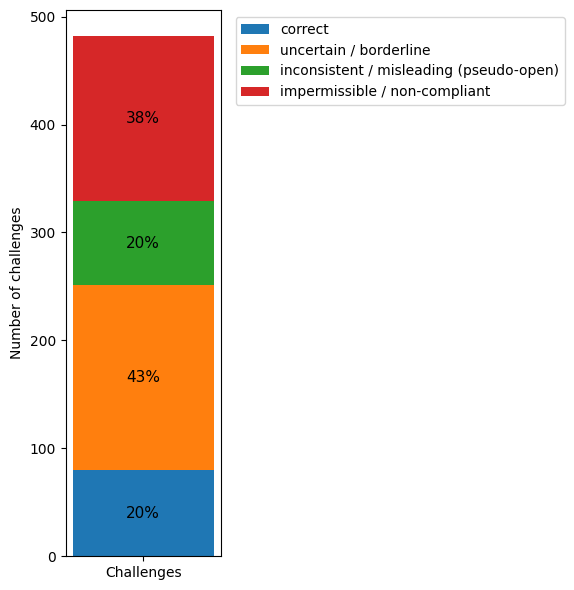

In [55]:
## Figure 3
inconsistencies_plot = inconsistencies_result.copy()
inconsistencies_plot = inconsistencies_plot.sort_values("Count")

incons_order = ["correct", "uncertain / borderline", "inconsistent / misleading (pseudo-open)",
                "impermissible / non-compliant"]

inconsistencies_plot = (inconsistencies_plot.set_index("Item").loc[incons_order].reset_index())

fig, ax = plt.subplots(figsize=(6, 6))

bottom = 0
for _, row in inconsistencies_plot.iterrows():
    ax.bar("Challenges", row["Count"], bottom=bottom, label=row["Item"])

    if row["Percentage"] > 1:
        ax.text(0, bottom + row["Count"] / 2, f'{row["Percentage"]:.0f}%', ha="center", va="center", fontsize=11)

    bottom += row["Count"]

ax.set_ylabel("Number of challenges")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

## Table 1
This section reproduces the analyses underlying the results presented in **Table 1**.

In [56]:
print(inconsistencies_task)

                                                Item  Count  Percentage
0    Platform registration under restrictive license    131        32.9
1            Additional data use agreement mentioned     91        22.9
2    Approval-based access under restrictive license     80        20.1
3                                 No inconsistencies     80        20.1
4      Conflicting license statements across sources     78        19.6
5                               NoDerivatives clause     71        17.8
6                    License missing or not findable     64        16.1
7         Platform registration despite open license     51        12.8
8   Context-limited access under restrictive license     39         9.8
9           Declared license without accessible data     32         8.0
10        Approval-based access despite open license     20         5.0
11        Conflicting or contradictory license terms     11         2.8
12       Context-limited access despite open license     10     

## Widespread reporting gaps hinder reusability and reproducibility
This section reproduces the analyses underlying the results reported in the subsection **“Widespread reporting gaps hinder reusability and reproducibility”**.

In [57]:
# Website not working
websites = count_items_per_task(df, "Multiple websites?")
print(websites)

                  Item  Count  Percentage
0                   No    405        88.4
1                  Yes     48        10.5
2  Website not working     12         2.6
3                Other      2         0.4


In [58]:
## Award reporting
award_not_reported_pct = award_type.loc[award_type["Item"] == "Not reported", "Percentage"].iloc[0]
print(f"Award type was not reported in {award_not_reported_pct:.1f}%")

# Amount of money
award_raw = df["Amount of money (summed up)"].dropna().astype(str).str.strip()
award_valid = award_raw[~award_raw.str.lower().eq("not applicable")]

# Count how often the award money was not reported
n_not_reported = award_valid.str.lower().eq("not reported").sum()
n_valid_total = len(award_valid)
perc_not_reported = (n_not_reported / n_valid_total * 100).round(1)

print(f"Award money not reported in {perc_not_reported}%")

Award type was not reported in 43.0%
Award money not reported in 55.8%


In [59]:
# Information on devices
print(
    f"Information on devices was absent in "
    f"{100 - nb_devices.loc[0, 'Percentage reported']:.1f}%"
)

Information on devices was absent in 43.4%


In [60]:
# Reporting of data splitting strategy
data_split = count_items_per_task(df, "Was it described how and why data was partitioned into training, validation and test sets?")
print(data_split)

                             Item  Count  Percentage
0           Only partly described    200        43.9
1            Not described at all    168        36.8
2  Described in sufficient detail     88        19.3


In [61]:
# Reporting of d meta data
meta_data_descr = count_items_per_task(df, "Meta data sufficiently described?")
print(meta_data_descr)

                             Item  Count  Percentage
0           Only partly described    185        41.4
1  Described in sufficient detail    150        33.6
2            Not described at all    112        25.1


In [62]:
# Reporting on data de-identification
data_anon = count_items_per_task(df, "Is the data (pseudo) anonymized or other forms of de-identification applied?")
print(data_anon)

           Item  Count  Percentage
0           Yes    256        60.7
1  Not reported    166        39.3


In [63]:
# Reporting on ethics committee approval
ethics_appr = count_items_per_task(df, "Ethics committee approval?")
print(ethics_appr)

           Item  Count  Percentage
0           Yes    218        64.3
1  Not reported    118        34.8
2     Partially      2         0.6
3            No      1         0.3


In [64]:
# Reporting of study population
population = count_items_per_task(df, "Description of the population?")
print(population)

                             Item  Count  Percentage
0            Not described at all    174        40.9
1           Only partly described    172        40.5
2  Described in sufficient detail     79        18.6


In [65]:
# Reporting of clinical information
clinical_info = count_items_per_task(df, "Clinical information on subjects provided?")
print(clinical_info)

                             Item  Count  Percentage
0           Only partly described    179        42.9
1            Not described at all    167        40.0
2  Described in sufficient detail     71        17.0


In [66]:
# Reporting of selection criteria of images/videos
selec_crit = count_items_per_task(df, "Selection criteria of images/videos described?")
print(selec_crit)

                             Item  Count  Percentage
0            Not described at all    219        48.7
1           Only partly described    134        29.8
2  Described in sufficient detail     97        21.6


In [67]:
# Reporting of eligibility criteria
elig_crit = count_items_per_task(df, "Eligibility criteria (is specified how, where and when potentially eligible participants for the study were identified (e.g. symptoms, results from previous tests, inclusion in registry, patient-care setting, location, dates)) described?")
print(elig_crit)

                             Item  Count  Percentage
0            Not described at all    208        50.4
1           Only partly described    132        32.0
2  Described in sufficient detail     73        17.7


In [68]:
# Reporting on sex distribution
perc_reported_male = percentage_male
perc_reported_female = percentage_female

print(f"Sex distribution was only reported in {perc_reported_male}% (male)")
print(f"Sex distribution was only reported in {perc_reported_female}% (female)")

Sex distribution was only reported in 29.9% (male)
Sex distribution was only reported in 29.9% (female)


In [69]:
## Reporting on age distribution

# Check how many tasks report all values
age_cols = ["If human data: minimum age", "If human data: mean age", 
            "If human data: median age", "If human data: maximum age"]

mask_all_reported = df[age_cols].apply(pd.to_numeric, errors="coerce").notna().all(axis=1)
n_all_reported = mask_all_reported.sum()

mask_any_reported = df[age_cols].apply(pd.to_numeric, errors="coerce").notna().any(axis=1)
n_any_reported = mask_any_reported.sum()

raw = df["If human data: minimum age"]
valid = raw[~raw.str.lower().eq("not applicable")]

n_total = len(valid)
share_all_reported = n_all_reported / n_total
share_any_reported = n_any_reported / n_total

print(f"Percentage of tasks reporting all details: {share_all_reported:.1%}")
print(f"Percentage of tasks reporting anything: {share_any_reported:.1%}")

Percentage of tasks reporting all details: 4.6%
Percentage of tasks reporting anything: 26.1%


In [70]:
# Reporting of annotation protocol
annot_prot = count_items_per_task(df, "Annotation protocol reported?")
print(annot_prot)

                             Item  Count  Percentage
0  Described in sufficient detail    152        39.5
1           Only partly described    145        37.7
2            Not described at all     88        22.9


In [71]:
# Reporting of annotation tools
annot_tools = count_items_per_task(df, "Annotation tools reported?")
print(annot_tools)

                             Item  Count  Percentage
0            Not described at all    160        41.6
1  Described in sufficient detail    146        37.9
2           Only partly described     79        20.5


In [72]:
# Reporting of inter-/intra-rater variability
inter_intra_rat = count_items_per_task(df, "Inter-/intra-rater variability reported?")
print(inter_intra_rat)

                             Item  Count  Percentage
0            Not described at all    247        74.0
1  Described in sufficient detail     51        15.3
2           Only partly described     35        10.5
3                         Unclear      1         0.3


## Figure 4
This section reproduces the analyses underlying the results presented in **Figure 4**.

C:\Users\reinkea\AppData\Local\Temp\ipykernel_21000\3668297493.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot = df_plot.fillna(0)


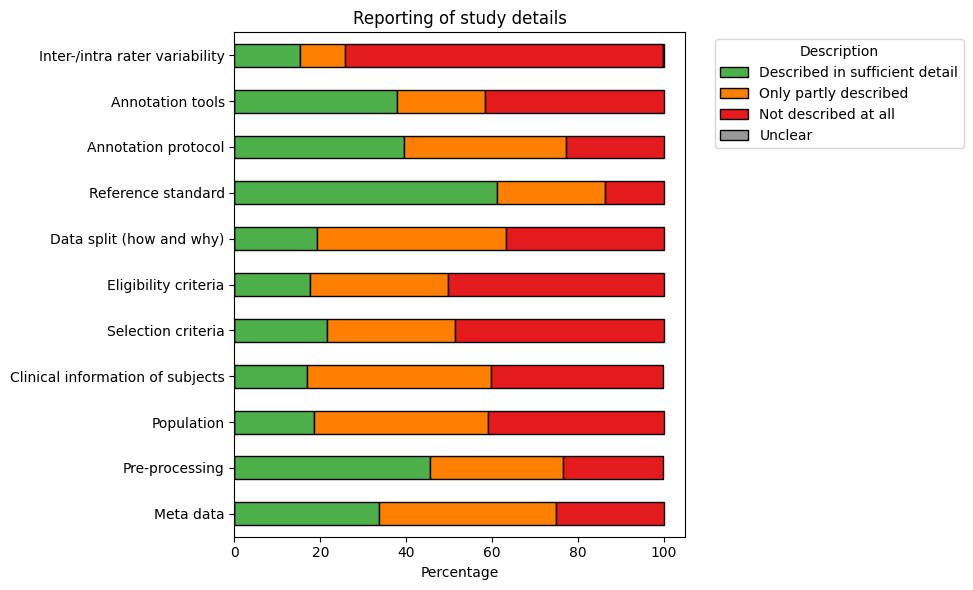

In [73]:
# Calculate additional reporting statistics
pre_proc = count_items_per_task(df, "If data preprocessing was applied: Is the procedure described in detail?")
ref_descr = count_items_per_task(df, "Is the reference standard sufficiently described?")

# Plot all reporting-related variables in one plot
reporting_order = ['Described in sufficient detail', 'Only partly described', 'Not described at all', 'Unclear']

meta_data_descr = (meta_data_descr.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
pre_proc = (pre_proc.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
population = (population.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
clinical_info = (clinical_info.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
selec_crit = (selec_crit.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
elig_crit = (elig_crit.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
data_split = (data_split.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
ref_descr = (ref_descr.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
annot_prot = (annot_prot.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
annot_tools = (annot_tools.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())
inter_intra_rat = (inter_intra_rat.set_index("Item").reindex(reporting_order, fill_value=0).reset_index())

reporting_dfs = [
    meta_data_descr, pre_proc, population, clinical_info, selec_crit, elig_crit,
    data_split, ref_descr, annot_prot, annot_tools, inter_intra_rat
]

reporting_labels = [
    "Meta data",
    "Pre-processing",
    "Population",
    "Clinical information of subjects",
    "Selection criteria",
    "Eligibility criteria",
    "Data split (how and why)",
    "Reference standard",
    "Annotation protocol",
    "Annotation tools",
    "Inter-/intra rater variability"
]

df_plot = pd.DataFrame(index=reporting_labels, columns=reporting_order)

for label, df in zip(reporting_labels, reporting_dfs):
    for _, row in df.iterrows():
        df_plot.loc[label, row["Item"]] = row["Percentage"]

df_plot = df_plot.fillna(0)

colors = ["#4daf4a", "#ff7f00", "#e41a1c", "#999999"]  
df_plot = df_plot.astype(float)

ax = df_plot.plot(kind="barh", stacked=True, figsize=(10, 6), color=colors, edgecolor="black")

plt.xlabel("Percentage")
plt.ylabel("")
plt.title("Reporting of study details")
plt.legend(title="Description", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Supplementary
This section reproduces the analyses underlying the results reported in the **“Supplementary Information”**.

In [74]:
## Suppl. Tab. 1
# clean data frame for supplements
participants_by_venue_suppl = participants_by_venue.drop(
    columns=["Count reported", "Percentage reported"]
)

participants_by_venue_suppl = participants_by_venue_suppl[
    ~participants_by_venue["Venue"].isin([
        "Endorsed by MICCAI",
        "SMRA",
        "KOSOMBE",
        "ML4H conference",
        "ACMMM",
        "EE-RDS",
        "ESTRO Physics Workshop",
        "ISICDM",
        "ECDP",
        "KOSOMBE"
    ])
]

print(participants_by_venue_suppl)

      Venue  Min     Mean  Median  IQR   Max
0    MICCAI    0    45.23      11   13  3308
1   NeurIPS    3    15.50      19   10    28
2      ISBI    2    18.63      14   14    62
7    Kaggle   14  1289.00    1347  962  2078
8      MIDL    6    18.00      18   12    30
11    ICIAR    4    25.33       8   45    64
14     SPIE   39    55.00      55   16    71


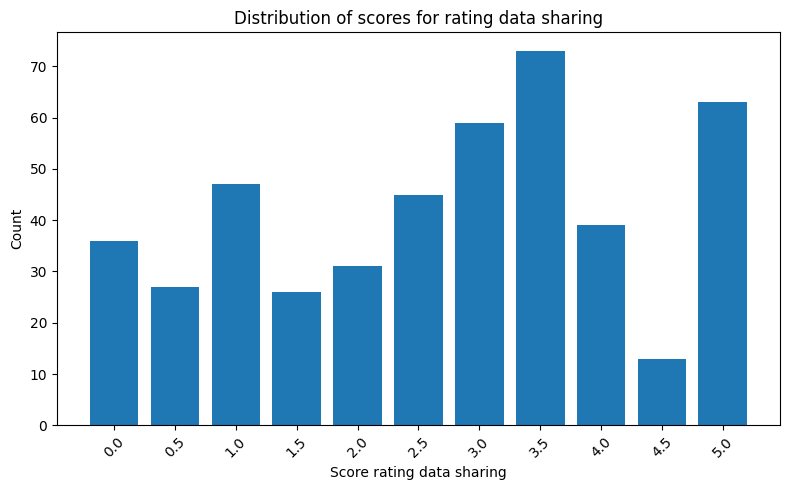

Score for rating data sharing
0.0    36
0.5    27
1.0    47
1.5    26
2.0    31
2.5    45
3.0    59
3.5    73
4.0    39
4.5    13
5.0    63
Name: count, dtype: int64


In [75]:
## Suppl. Fig. 1
df_score_rating_counts = pd.DataFrame({
    "Value": score_data_sharing_value_countstest.index,
    "Count": score_data_sharing_value_countstest.values,
    "Percentage": (score_data_sharing_value_countstest.values / n_tasks * 100).round(1)
}).reset_index(drop=True)

plt.figure(figsize=(8, 5))
plt.bar(df_score_rating_counts["Value"].astype(str), df_score_rating_counts["Count"])
plt.xlabel("Score rating data sharing")
plt.ylabel("Count")
plt.title("Distribution of scores for rating data sharing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(score_data_sharing_value_countstest)

In [76]:
## Suppl. Tab. 2
print("=== Training ===")
print(nb_training)
print("\n=== Validation ===")
print(nb_val)
print("\n=== Test (final) ===")
print(nb_test)

=== Training ===
   Count reported  Percentage reported  Min     Mean  Median   IQR     Max
0             429                 93.9    0  4246.49     288  1130  530706

=== Validation ===
   Count reported  Percentage reported  Min    Mean  Median  IQR    Max
0             156                 91.2    1  411.87      80  170  18368

=== Test (final) ===
   Count reported  Percentage reported  Min    Mean  Median  IQR    Max
0             394                 86.2    1  704.81     102  324  47227


In [77]:
## Suppl. Tab 3
stats_male = {
        "Count reported": count_male,
        "Percentage reported": percentage_male,
        "Min": int(values_male.min()),
        "Mean": round(values_male.mean(), 2),
        "Median": int(values_male.median()),
        "IQR": int(np.percentile(values_male, 75) - np.percentile(values_male, 25)),
        "Max": int(values_male.max())
    }

stats_female = {
        "Count reported": count_female,
        "Percentage reported": percentage_female,
        "Min": int(values_female.min()),
        "Mean": round(values_female.mean(), 2),
        "Median": int(values_female.median()),
        "IQR": int(np.percentile(values_female, 75) - np.percentile(values_female, 25)),
        "Max": int(values_female.max())
    }

print("Male\n", pd.DataFrame([stats_male]))
print("\nFemale\n", pd.DataFrame([stats_female]))

Male
    Count reported  Percentage reported  Min   Mean  Median  IQR  Max
0             124                 29.9    0  47.63      52   26  100

Female
    Count reported  Percentage reported  Min   Mean  Median  IQR  Max
0             124                 29.9    0  52.37      47   26  100


In [78]:
## Suppl. Tab. 4
print("Minimum age\n", age_min)
print("\nMean age\n", age_mean)
print("\nMedian age\n", age_median)
print("\nMaximum age\n", age_max)

Minimum age
    Count reported  Percentage reported  Min   Mean  Median  IQR  Max
0              80                 19.0    0  21.98      19    8   55

Mean age
    Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0              77                 18.3    0  49.9      54   13   72

Median age
    Count reported  Percentage reported  Min   Mean  Median  IQR  Max
0              29                  7.0    0  50.48      60   16   66

Maximum age
    Count reported  Percentage reported  Min  Mean  Median  IQR  Max
0              76                 18.1    0  73.3      83   23  100
